In [1]:
import numpy as np
import pandas as pd

In [5]:
df=pd.read_csv("/content/dataset.zip")
df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


# Step 1: Data Structure Validation

In [6]:
# 1. Check basic structure
print(f"Data shape: {df.shape}")
print(f"Subjects: {df['subject'].nunique()}")
print(f"Conditions: {df['condition'].unique()} -> {['normal', 'knee_brace', 'ankle_brace']}")
print(f"Missing values: {df.isnull().sum().sum()}")

# 2. Verify time series structure
time_points_per_cycle = df.groupby(['subject','condition','replication','leg','joint'])['time'].count()
print(f"Time points per cycle: {time_points_per_cycle.unique()}")

Data shape: (181800, 7)
Subjects: 10
Conditions: [1 2 3] -> ['normal', 'knee_brace', 'ankle_brace']
Missing values: 0
Time points per cycle: [101]


In [7]:
group_cols=['subject','condition','replication','leg','joint']

# Step 2: Feature engineering

In [27]:
df['velocity'] = df.groupby(group_cols)['angle'].diff() / df.groupby(group_cols)['time'].diff()
df['velocity'] = df['velocity'].interpolate(method='linear', limit_direction='both')
df['velocity'].head()

,velocity
0,0.390246
1,0.390246
2,0.156647
3,0.146502
4,0.430874


In [28]:
df['acceleration']=df.groupby(group_cols)['velocity'].diff()/df.groupby(group_cols)['time'].diff()
df['acceleration'] = df['acceleration'].interpolate(method='linear', limit_direction='both')
df['acceleration'].head()

,acceleration
0,0.000000
1,0.000000
2,0.233599
3,0.010145
4,0.284372


In [29]:
df['jerk'] = df['acceleration'].diff() / df['time'].diff()
df['jerk']=df['jerk'].interpolate(method='spline', order=3, limit_direction='both')
df['jerk'].head()

,jerk
0,0.000888
1,0.000000
2,0.233599
3,0.223454
4,0.274227


In [11]:
df.head()

,subject,condition,replication,leg,joint,time,angle,velocity,acceleration,jerk
0,1,1,1,1,1,0,4.682881,0.390246,0.000000,0.000883
1,1,1,1,1,1,1,5.073127,0.390246,0.000000,0.000000
2,1,1,1,1,1,2,5.229774,0.156647,-0.233599,-0.233599
3,1,1,1,1,1,3,5.083273,-0.146502,-0.303149,-0.069549
4,1,1,1,1,1,4,4.652399,-0.430874,-0.284372,0.018776


#Step 3: EDA

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Basic Stats per condition
print("Key Stats by Condition:")
print(df.groupby('condition')[['angle', 'velocity', 'acceleration', 'jerk']].agg(['mean', 'std']).round(3))

Key Stats by Condition:
            angle         velocity        acceleration          jerk       
             mean     std     mean    std         mean    std   mean    std
condition                                                                  
1          13.350  17.147   -0.000  1.406        0.001  0.228  0.001  0.086
2          12.127  13.608   -0.001  1.151        0.000  0.209  0.000  0.085
3          10.971  16.984   -0.001  1.315        0.001  0.205  0.001  0.077


**Here condition 1 (Unbraced) has highest mean- angle, velocity, acceleration, jerk and variability i.e Normal legs are having dynamic movements. So, we can consider them ideal and can compare them with movements of legs in condition 2 and 3.**

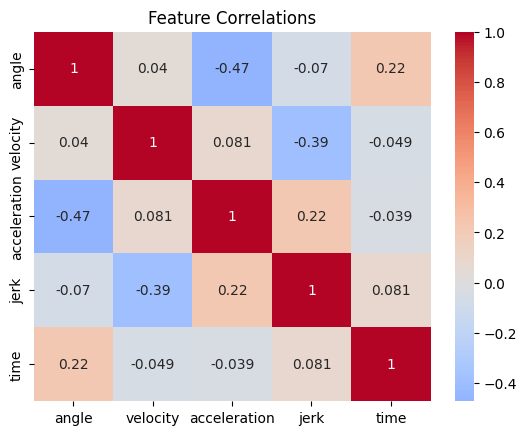

In [14]:
# Correlations of diff features
corr_matrix = df[['angle', 'velocity', 'acceleration', 'jerk', 'time']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

**From matrix we can say that jerk is not highly correlated with time i.e not neccessarly with time smoothness will increase. But it is correlated with velocity and acceleration as they are diretly propotional.**

/tmp/ipython-input-2976966805.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['condition_name'] = sample['condition'].map(condition_names)


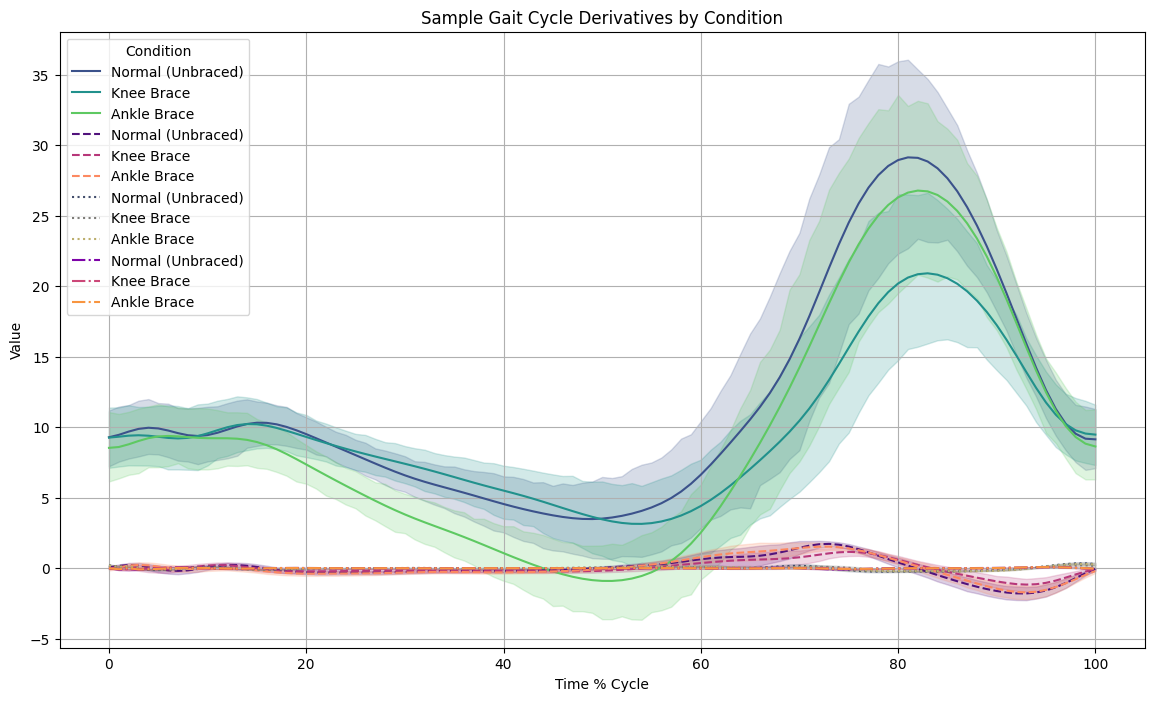

In [15]:
# Sample Gait Cycle Derivatives by Condition
sample = df[
    df['subject'].isin([1, 2, 3]) &
    df['condition'].isin([1, 2, 3]) &
    df['replication'].isin([1, 2, 3]) &
    df['leg'].isin([1, 2]) &
    df['joint'].isin([1, 2, 3])
]

# Map condition numbers to names for better readability
condition_names = {1: 'Normal (Unbraced)', 2: 'Knee Brace', 3: 'Ankle Brace'}
sample['condition_name'] = sample['condition'].map(condition_names)

plt.figure(figsize=(14, 8))

# Plot Angle
sns.lineplot(x='time', y='angle', hue='condition_name', data=sample, palette='viridis')
# Plot Velocity
sns.lineplot(x='time', y='velocity', hue='condition_name', data=sample, palette='magma', linestyle='--')
# Plot Acceleration
sns.lineplot(x='time', y='acceleration', hue='condition_name', data=sample, palette='cividis', linestyle=':')
# Plot Jerk
sns.lineplot(x='time', y='jerk', hue='condition_name', data=sample, palette='plasma', linestyle='-.')

plt.xlabel('Time % Cycle')
plt.ylabel('Value')
plt.title('Sample Gait Cycle Derivatives by Condition')
plt.legend(title='Condition')
plt.grid(True)
plt.show()

**Major variability except angle is in inital stage of cycle and after 60% cycle**

In [16]:
# Anomaly preview: High jerk outliers by condition
high_jerk_thresh = df['jerk'].quantile(0.95)  # Top 5%
jerk_percentages = df.groupby('condition')['jerk'].apply(lambda x: (x > high_jerk_thresh).mean() * 100)
print("High Jerk Instances (%):")
for condition, percentage in jerk_percentages.items():
    print(f"Condition {condition}: {percentage:.1f}%")

High Jerk Instances (%):
Condition 1: 5.6%
Condition 2: 5.3%
Condition 3: 4.1%


**only 4.1–5.6% of instances exceed the 95th percentile jerk threshold indicating a good stability**

# Residuals and Phase Segmentation

In [17]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

# Phase assignment
df['phase'] = np.where(df['time'] <= 60, 'stance', 'swing')

# Simple deviation from cond=1 mean (angle at time/joint)
normal_mean = df[df['condition'] == 1].groupby(['joint', 'time'])['angle'].mean().reset_index(name='angle_normal')

# Drop existing 'angle_normal' or 'angle_normal_x' columns to prevent merge conflicts in reruns
df = df.drop(columns=[col for col in df.columns if 'angle_normal' in col], errors='ignore')

df = df.merge(normal_mean, on=['joint', 'time'], how='left')
df['deviation'] = np.abs(df['angle'] - df['angle_normal'].fillna(df['angle']))

# KernelRidge for residuals (smooth cond=1 fits)
normal_data = df[df['condition'] == 1].copy()
df['kr_residual'] = 0.0
df['kr_deviation'] = 0.0

joints = sorted(df['joint'].unique())
legs = sorted(df['leg'].unique())
for joint in joints:
    for leg in legs:
        norm_sub = normal_data[(normal_data['joint'] == joint) & (normal_data['leg'] == leg)]
        if len(norm_sub) < 20: continue
        times = norm_sub['time'].values.reshape(-1, 1)
        angles = norm_sub['angle'].values
        # Cyclic duplication
        # To ensure consistent lengths and handle cyclic data, append the first point to the end.
        times_cyc = np.vstack([times, times[0:1]])
        angles_cyc = np.hstack([angles, angles[0]])
        # Fit
        kr = KernelRidge(alpha=0.01, kernel='rbf', gamma=0.1)
        kr.fit(times_cyc, angles_cyc)
        # Apply to all
        all_sub_idx = df[(df['joint'] == joint) & (df['leg'] == leg)].index
        times_all = df.loc[all_sub_idx, 'time'].values.reshape(-1, 1)
        pred = kr.predict(times_all)
        resids = df.loc[all_sub_idx, 'angle'].values - pred
        df.loc[all_sub_idx, 'kr_residual'] = resids
        df.loc[all_sub_idx, 'kr_deviation'] = np.abs(resids)

# Preprocessing and Labeling

In [18]:
normal_kr_res = df[df['condition'] == 1]['kr_residual']
kr_thresh = np.mean(normal_kr_res) + 2 * np.std(normal_kr_res)
y_micro = (df['kr_deviation'] > kr_thresh).astype(int)

df_encoded = pd.get_dummies(df, columns=['joint', 'leg', 'phase'], prefix=['joint', 'leg', 'phase'])
numeric_feats = ['deviation', 'kr_deviation', 'kr_residual', 'velocity', 'acceleration', 'jerk', 'angle', 'time']
scaler = StandardScaler()
df_encoded[numeric_feats] = scaler.fit_transform(df_encoded[numeric_feats].fillna(0))

X_micro = df_encoded[numeric_feats + [c for c in df_encoded if c.startswith(('joint_', 'leg_', 'phase_'))]]

print(f"Ready: {X_micro.shape}, Anomalies: {y_micro.mean():.1%}")
print(df[['condition', 'joint', 'time', 'kr_deviation', 'jerk', 'phase']].head(10).round(3))

Ready: (181800, 15), Anomalies: 13.8%
   condition  joint  time  kr_deviation   jerk   phase
0          1      1     0         0.218  0.001  stance
1          1      1     1         0.511  0.000  stance
2          1      1     2         0.882 -0.234  stance
3          1      1     3         1.275 -0.070  stance
4          1      1     4         1.682  0.019  stance
5          1      1     5         2.090  0.100  stance
6          1      1     6         2.495  0.150  stance
7          1      1     7         2.893  0.157  stance
8          1      1     8         3.263  0.124  stance
9          1      1     9         3.584  0.066  stance


# Data Splitting

In [19]:
from sklearn.model_selection import GroupKFold

# Trial IDs as groups (unique per subject-cond-repl)
df['trial_id'] = df['subject'].astype(str) + '_' + df['condition'].astype(str) + '_' + df['replication'].astype(str)
groups = df['trial_id'].values
gkf = GroupKFold(n_splits=5)  # 5 folds for speed

folds = list(gkf.split(X_micro, y_micro, groups))
print(f"Created {len(folds)} folds. Example: Train {len(folds[0][0])} / Test {len(folds[0][1])} instances")

Created 5 folds. Example: Train 145440 / Test 36360 instances


# Modeling

In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
import warnings; warnings.filterwarnings('ignore')

# Normal instances for training (cond=1)
normal_mask = (df['condition'] == 1).values
X_normal_micro = X_micro[normal_mask]

# Base models (tuned for micro: lower contamination=0.05)
models = {
    'IF': IsolationForest(contamination=0.05, random_state=42, n_estimators=100),
    'LOF': LocalOutlierFactor(n_neighbors=50, contamination=0.05, novelty=True),
    'OCSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
}

# CV evaluation
aucs = {name: [] for name in models}
for train_idx, test_idx in folds:
    train_normal_idx = np.intersect1d(train_idx, np.where(normal_mask)[0])
    X_train_n = X_micro.iloc[train_normal_idx]

    for name, model in models.items():
        model.fit(X_train_n)
        pred_prob = -model.decision_function(X_micro.iloc[test_idx])
        y_test = y_micro.iloc[test_idx]
        aucs[name].append(roc_auc_score(y_test, pred_prob))

print("Micro CV AUCs:", {k: f"{np.mean(v):.3f} ± {np.std(v):.3f}" for k, v in aucs.items()})

Micro CV AUCs: {'IF': '0.971 ± 0.004', 'LOF': '0.826 ± 0.011', 'OCSVM': '0.808 ± 0.007'}


* **Here Isolation forest performed best**

* **LOF is based on local neighbor densities and considering 1% as indivival instance made cluster a bit tight and sensitive for outlier**
* **In case of OCSVM Kernel Boundary got Rigid.**

# Ensembling

In [21]:
from sklearn.metrics import precision_recall_curve

# Fit full on normals
for name, model in models.items():
    if name != 'LOF':
        model.fit(X_normal_micro)

# Full micro predictions
pred_if = -models['IF'].decision_function(X_micro)
pred_lof = -models['LOF'].decision_function(X_micro)
pred_ocsvm = -models['OCSVM'].decision_function(X_micro)

# Weighted ensemble
ensemble_micro = 0.4 * pred_if + 0.3 * pred_lof + 0.3 * pred_ocsvm

# Optimize threshold
val_idx = np.random.choice(len(X_micro), int(0.2 * len(X_micro)), replace=False)
prec, rec, thresh = precision_recall_curve(y_micro.iloc[val_idx], ensemble_micro[val_idx])
opt_idx = np.argmax(prec * rec)
opt_thresh = thresh[opt_idx] if len(thresh) > 0 else ensemble_micro.mean()
print(f"Micro Optimal Threshold: {opt_thresh:.3f}")

ensemble_micro_bin = (ensemble_micro > opt_thresh).astype(int)

Micro Optimal Threshold: 0.362


# Evaluation

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
# Metrics
auc_micro = roc_auc_score(y_micro, ensemble_micro)
print(f"Micro Ensemble AUC: {auc_micro:.3f}")
print("\nInstance-Level Report:\n", classification_report(y_micro, ensemble_micro_bin))

cm = confusion_matrix(y_micro, ensemble_micro_bin)
print("\nMicro Confusion Matrix:\n", cm)

Micro Ensemble AUC: 0.810

Instance-Level Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94    156682
           1       0.66      0.49      0.56     25118

    accuracy                           0.89    181800
   macro avg       0.79      0.72      0.75    181800
weighted avg       0.89      0.89      0.89    181800


Micro Confusion Matrix:
 [[150446   6236]
 [ 12893  12225]]


In [24]:
# Explanations: Anomaly hotspots
df['anomaly_score'] = ensemble_micro
df['anomaly_flag'] = ensemble_micro_bin

# By time/joint/phase
hotspots = df.groupby(['time', 'joint', 'phase']).agg({
    'anomaly_flag': 'mean',  # % anomalous instances
    'deviation': 'mean'
}).reset_index()
print("\nTop Hotspots (High % Anomalous):\n", hotspots.nlargest(10, 'anomaly_flag'))


Top Hotspots (High % Anomalous):
      time  joint   phase  anomaly_flag  deviation
7       2      2  stance      0.841667   3.800969
6       2      1  stance      0.723333   3.660869
5       1      3  stance      0.550000   3.150094
210    70      1   swing      0.465000   6.835374
8       2      3  stance      0.461667   3.128472
207    69      1   swing      0.461667   6.683236
213    71      1   swing      0.450000   6.798294
216    72      1   swing      0.443333   6.605769
4       1      2  stance      0.441667   3.927194
204    68      1   swing      0.433333   6.283099


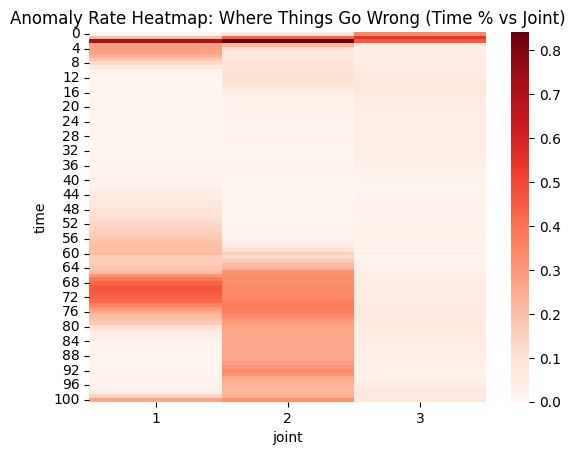


Cond 2 Anomalies by Joint/Phase:
phase    stance     swing
joint                    
1      0.087541  0.282375
2      0.055492  0.514375
3      0.103279  0.113375

Cond 3 Anomalies by Joint/Phase:
phase    stance    swing
joint                   
1      0.121230  0.10400
2      0.064344  0.23775
3      0.034590  0.00350


In [25]:
# Heatmap of anomalies by time/joint
pivot_anom = hotspots.pivot_table(values='anomaly_flag', index='time', columns='joint')
sns.heatmap(pivot_anom, cmap='Reds', annot=False)
plt.title('Anomaly Rate Heatmap: Where Things Go Wrong (Time % vs Joint)')
plt.show()

# Per-condition breakdown
for cond in [2, 3]:
    mask = df['condition'] == cond
    sub = df[mask].groupby(['joint', 'phase'])['anomaly_flag'].mean().unstack()
    print(f"\nCond {cond} Anomalies by Joint/Phase:\n{sub}")

In [26]:

df.to_csv('micro_gait_anomalies.csv', index=False)
print("\nMicro results saved to micro_gait_anomalies.csv")


Micro results saved to micro_gait_anomalies.csv


# Conclusion
* Accuracy is 89% with 0.81 AUC
* Most of anomalies were detacted on swing part especially for keen joint